# Langevin Sampling

Langevin dynamics provide an MCMC procedure to sample from a distribution $p(x)$ using unly its score function $\nabla_{x}log\:p(x)$. Specifically, it initializes the chain from an arbitary prior distribution $x_0 \sim \pi(x)$, and then iterates the following:

$$
x_{i+1} \leftarrow x_i + \epsilon \nabla_x log\:p(x) + \sqrt{2\epsilon}\:z_i
$$

where, $i = 0, 1, ... K$ and $z_i \sim \mathcal{N}(0, I)$.

1. $\sqrt{2\epsilon}\:z_i$ injects the noise in the procedure, which generates the whole distribution rather than converging to a maxima of the `pdf` f original distribution.
2. $\epsilon$ is a scaling factor, akin to hyperparameter, that lets us control the magnitude of the step in the gradient direction.

### Let's construct a `original` distribution

In [ ]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"  # Must be before importing JAX
import jax

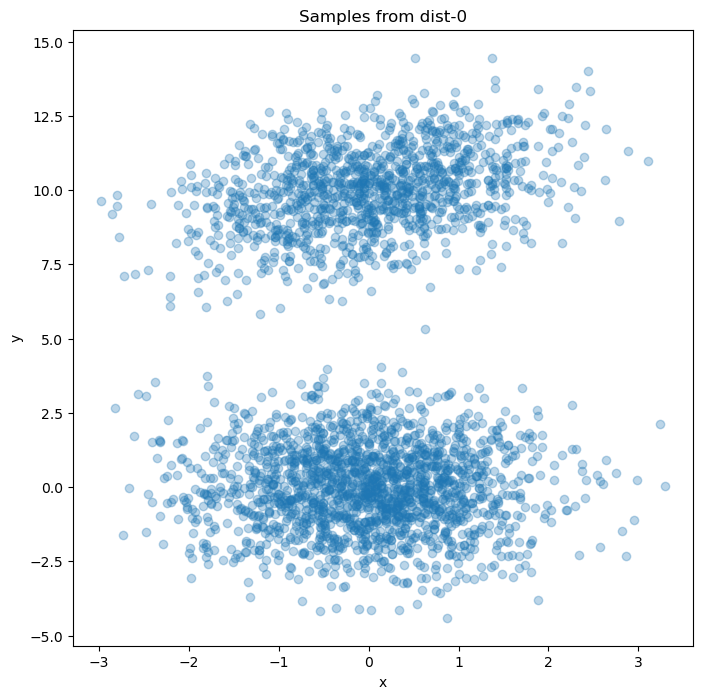

In [56]:
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt

mean1, cov1 = jnp.array([0.0, 0.0]), jnp.array([[1.0, 0.0], [0.0, 2.0]])
mean2, cov2 = jnp.array([0.0, 10.0]), jnp.array([[1.0, -1.0], [2.0, 2.0]])

def generate_original_distribution(mean1, cov1, mean2, cov2, num_samples=3000, p=0.5):
    jax_prng_key = jax.random.key(42)
    samples1 = random.multivariate_normal(jax_prng_key, mean1, cov1, (num_samples,))
    samples2 = random.multivariate_normal(jax_prng_key, mean2, cov2, (num_samples,))
    
    # Sampling from a combination of the two distribution to get a non-trivial distribution.
    choice = random.bernoulli(jax_prng_key, p=p, shape=(num_samples,))
    samples = jnp.where(choice[:, None], samples1, samples2)
    return samples

samples = generate_original_distribution(mean1, cov1, mean2, cov2, num_samples=3000, p=0.6)

def plot_distribution(samples, title):
    plt.figure(figsize=(8, 8))
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.3)
    plt.title(f"Samples from {title}")
    plt.xlabel("x")
    plt.ylabel("y")
    # plt.show()
    
plot_distribution(samples, "dist-0")

### Getting the Score Function for the above 2 degree Gaussian Mixture Model(GMM)
$$p(x)=p⋅N(x∣μ_1​,Σ_1​)+(1−p)⋅N(x∣μ_2​,Σ_2​)$$

Let:
$$p_k(x)=N(x∣μ_k,Σ_k),k=1,2$$
$$p_k​(x)=N(x∣μ_k​,Σ_k​),k=1,2$$

The score is:
$$∇_xlog⁡p(x)=p⋅∇_xp_1(x)+(1−p)⋅∇_xp_2(x)p(x)$$
$$∇_x​logp(x)=p(x)p⋅∇_x​p_1​(x)+(1−p)⋅∇x_​p_2​(x)​$$

And:
$$∇_xlog⁡p_k(x)=−Σ_k^{−1}(x−μ_k)$$
$$∇_x​logp_k​(x)=−Σ_k^{−1}​(x−μ_k​)$$

So:
$$∇_xlog⁡p(x)=p⋅p_1(x)⋅[−Σ_1^{−1}(x−μ_1)]+(1−p)⋅p_2(x)⋅[−Σ_2^{−1}(x−μ_2)]p⋅p_1(x)+(1−p)⋅p_2(x)$$
$$∇_x​logp(x)=p⋅p_1​(x)+(1−p)⋅p_2​(x)p⋅p_1​(x)⋅[−Σ_1^{−1}​(x−μ_1​)]+(1−p)⋅p_2​(x)⋅[−Σ_2^{−1}​(x−μ_2​)]​$$

This is a weighted average of component scores, weighted by their responsibilities (posterior probabilities).

In [57]:
import jax.numpy as jnp
from jax.scipy.stats import multivariate_normal as mvn

def gmm_score(x, mean1, cov1, mean2, cov2, p):
    inv_cov1 = jnp.linalg.inv(cov1)
    inv_cov2 = jnp.linalg.inv(cov2)

    # Broadcast means for batch shape
    mean1_b = jnp.broadcast_to(mean1, x.shape)
    mean2_b = jnp.broadcast_to(mean2, x.shape)

    # Evaluate Gaussian PDFs
    p1 = mvn.pdf(x, mean1, cov1)
    p2 = mvn.pdf(x, mean2, cov2)

    # Score terms (N, 2)
    score1 = -(x - mean1_b) @ inv_cov1.T
    score2 = -(x - mean2_b) @ inv_cov2.T

    mix_pdf = p * p1 + (1 - p) * p2
    weighted_score = (p * p1[:, None] * score1 + (1 - p) * p2[:, None] * score2) / (mix_pdf[:, None] + 1e-8)
    return weighted_score


In [58]:
p = 0.6
def score_fn(x):
    return gmm_score(x, mean1, cov1, mean2, cov2, p)

### Langevin Sampling

In [82]:
from ipywidgets import interact, IntSlider
import numpy as np

def langevin_step(prev_x, score_fn, epsilon):
    z = np.random.randn(*prev_x.shape)
    score_x = score_fn(prev_x)
    # print(score_x)
    new_x = prev_x + epsilon/2 * score_x + jnp.sqrt(epsilon) * z 
    return new_x

def start_sampling(inital_samples, score_fn, epsilon, num_steps):
    x_i = inital_samples
    samples_list = [x_i]
    for i in range(num_steps):
        x_i = langevin_step(x_i, score_fn, epsilon)
        samples_list.append(x_i)

    def plot_step(step):
        plt.figure(figsize=(8, 8))
        plt.scatter(samples_list[step][:, 0], samples_list[step][:, 1], alpha=0.3)
        plt.title(f"Samples at step {step}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xlim(-3, 3)
        plt.ylim(-5, 15)
        plt.show()

    interact(plot_step, step=IntSlider(min=0, max=num_steps, step=1, value=0, description='Step'))
    
import matplotlib.pyplot as plt
import imageio
import os

def start_sampling_with_gif(initial_samples, score_fn, epsilon, num_steps, gif_path="sampling.gif"):
    x_i = initial_samples
    samples_list = [x_i]

    for i in range(num_steps):
        x_i = langevin_step(x_i, score_fn, epsilon)
        samples_list.append(x_i)

    # Create temporary directory for frames
    os.makedirs("frames", exist_ok=True)
    frame_paths = []

    step_interval = max(1, num_steps // 10)
    for step in range(0, num_steps + 1, step_interval):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.scatter(samples_list[step][:, 0], samples_list[step][:, 1], alpha=0.3)
        ax.set_title(f"Samples at step {step}")
        ax.set_xlim(-3, 3)
        ax.set_ylim(-5, 15)
        ax.set_xlabel("x")
        ax.set_ylabel("y")

        frame_path = f"frames/frame_{step:03d}.png"
        frame_paths.append(frame_path)
        plt.savefig(frame_path)
        plt.close(fig)

    # Write GIF
    images = [imageio.imread(fp) for fp in frame_paths]
    imageio.mimsave(gif_path, images, duration=0.5)

    # Cleanup (optional)
    for fp in frame_paths:
        os.remove(fp)
    os.rmdir("frames")

    print(f"GIF saved to {gif_path}")



In [86]:
# Sample k points from a standard Gaussian
k = 5000
mean = jnp.array([0.0, 5.0])
cov = jnp.eye(2)
jax_prng_key = jax.random.key(42)
init_samples = random.multivariate_normal(jax_prng_key, mean, cov, (k,))

print(f"init_sample.shape: ", init_samples.shape)

# Run Langevin sampling
epsilon = 0.005
num_steps = 2000
# start_sampling(init_samples, score_fn, epsilon, num_steps)
start_sampling_with_gif(init_samples, score_fn, epsilon, num_steps)

init_sample.shape:  (5000, 2)


/tmp/ipykernel_26772/3795069880.py:62: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(fp) for fp in frame_paths]


GIF saved to sampling.gif
